In [1]:
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split


images_path = '/content/drive/MyDrive/RETOECHO/images.npy'
heatmaps_path = '/content/drive/MyDrive/RETOECHO/all_heatmapss.npy'

images = np.load(images_path)
heatmaps = np.load(heatmaps_path)

images= images[:7000]

In [2]:
print(images.shape)
print(heatmaps.shape)

(7000, 112, 112, 3)
(7000, 6, 112, 112)


# Split the data into training and testing sets


In [5]:
images = images.astype('float32')
heatmaps = heatmaps.astype('float32')

images = images / 255.0

train_images, valid_images, train_heatmaps, valid_heatmaps = train_test_split(
    images, heatmaps, test_size=0.4, random_state=42
)

print(f'Image min value: {train_images.min()}')
print(f'Image max value: {train_images.max()}')
print(f'heatmap min value: {heatmaps.min()}')
print(f'heatmap max value: {heatmaps.max()}')

Image min value: 0.0
Image max value: 1.0
heatmap min value: 0.0
heatmap max value: 1.0


# Reshape and Check the shape of the datasets


In [6]:
train_heatmaps = np.transpose(train_heatmaps, (0, 2, 3, 1))
valid_heatmaps = np.transpose(valid_heatmaps, (0, 2, 3, 1))

print("Train images shape:", train_images.shape)
print("Train heatmaps shape:", train_heatmaps.shape)
print("valid images shape:", valid_images.shape)
print("valid heatmaps shape:", valid_heatmaps.shape)


Train images shape: (4200, 112, 112, 3)
Train heatmaps shape: (4200, 112, 112, 6)
valid images shape: (2800, 112, 112, 3)
valid heatmaps shape: (2800, 112, 112, 6)


In [7]:
valid_images, test_images, valid_heatmaps, test_heatmaps = train_test_split(
    valid_images, valid_heatmaps, test_size=0.071, random_state=42
)

In [8]:
print("valid images shape:", valid_images.shape)
print("valid heatmaps shape:", valid_heatmaps.shape)
print("test images shape:", test_images.shape)
print("test heatmaps shape:", test_heatmaps.shape)

valid images shape: (2601, 112, 112, 3)
valid heatmaps shape: (2601, 112, 112, 6)
test images shape: (199, 112, 112, 3)
test heatmaps shape: (199, 112, 112, 6)


In [ ]:
!pip install tensorflow_addons

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import math

print(train_images.shape)
print(train_heatmaps.shape)

def rotate_image_and_heatmap(image, heatmap, degrees=20):
    angle = math.radians(degrees)

    if len(image.shape) < 3:
        image = tf.expand_dims(image, axis=-1)
    if len(heatmap.shape) < 3:
        heatmap = tf.expand_dims(heatmap, axis=-1)

    # Rotate image and heatmap
    rotated_image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
    rotated_heatmap = tfa.image.rotate(heatmap, angle, interpolation='BILINEAR')
    return rotated_image, rotated_heatmap

def augment_data(images, heatmaps, num_to_augment, times=3):
    augmented_images = []
    augmented_heatmaps = []

    # Adjust the loop to iterate only over the first num_to_augment images
    for i in range(min(num_to_augment, len(images))):
        image = tf.cast(images[i], tf.float32)  # Convert to float32
        heatmap = tf.cast(heatmaps[i], tf.float32)  # Convert to float32

        augmented_images.append(image)
        augmented_heatmaps.append(heatmap)

        for t in range(times):
            if t == 0:  # Rotate 20 degrees
                aug_image, aug_heatmap = rotate_image_and_heatmap(image, heatmap, degrees=20)
            elif t == 1:  # Zoom 0.2
                aug_image = tf.image.central_crop(image, central_fraction=0.8)
                aug_image = tf.image.resize(aug_image, [112, 112])
                aug_heatmap = tf.image.central_crop(heatmap, central_fraction=0.8)
                aug_heatmap = tf.image.resize(aug_heatmap, [112, 112])
            elif t == 2:  # Horizontal flip
                aug_image = tf.image.flip_left_right(image)
                aug_heatmap = tf.image.flip_left_right(heatmap)

            augmented_images.append(tf.cast(aug_image, tf.float32))  # Convert to float32
            augmented_heatmaps.append(tf.cast(aug_heatmap, tf.float32))  # Convert to float32

    return tf.convert_to_tensor(augmented_images), tf.convert_to_tensor(augmented_heatmaps)

# Set the number of images to augment
num_to_augment = 2067

augmented_images, augmented_heatmaps = augment_data(train_images, train_heatmaps, num_to_augment)

print("Augmented images shape:", augmented_images.shape)
print("Augmented heatmaps shape:", augmented_heatmaps.shape)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


(4200, 112, 112, 3)
(4200, 112, 112, 6)
Augmented images shape: (8268, 112, 112, 3)
Augmented heatmaps shape: (8268, 112, 112, 6)


# we define the metric dice_coefficient


In [11]:
def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

# Modified U net model to generate 6 heatmaps per image

In [12]:
def unet_model_for_heatmaps(input_size=(112, 112, 3), num_classes=6, dropout_rate=0.2):
    inputs = keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(dropout_rate)(pool1)  # Dropout after pooling

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.Dropout(dropout_rate)(pool2)  # Dropout after pooling

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = layers.Dropout(dropout_rate)(pool3)  # Dropout after pooling

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = layers.Dropout(dropout_rate)(pool4)  # Dropout after pooling

    # Bottleneck
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model_for_heatmaps()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[dice_coefficient])

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# We train the model with 30 epochs

In [13]:
history = model.fit(
    train_images,
    train_heatmaps,
    validation_data=(valid_images, valid_heatmaps),
    epochs=30,
    batch_size=32
)


Epoch 1/30
132/132 [==============================] - 76s 400ms/step - loss: 0.1624 - dice_coefficient: 0.0097 - val_loss: 0.0193 - val_dice_coefficient: 0.0217
Epoch 2/30
132/132 [==============================] - 47s 359ms/step - loss: 0.0174 - dice_coefficient: 0.0323 - val_loss: 0.0152 - val_dice_coefficient: 0.0569
Epoch 3/30
132/132 [==============================] - 49s 371ms/step - loss: 0.0137 - dice_coefficient: 0.0977 - val_loss: 0.0127 - val_dice_coefficient: 0.1216
Epoch 4/30
132/132 [==============================] - 50s 379ms/step - loss: 0.0124 - dice_coefficient: 0.1373 - val_loss: 0.0120 - val_dice_coefficient: 0.1420
Epoch 5/30
132/132 [==============================] - 51s 384ms/step - loss: 0.0119 - dice_coefficient: 0.1509 - val_loss: 0.0117 - val_dice_coefficient: 0.1582
Epoch 6/30
132/132 [==============================] - 51s 386ms/step - loss: 0.0115 - dice_coefficient: 0.1613 - val_loss: 0.0116 - val_dice_coefficient: 0.1652
Epoch 7/30
132/132 [==============

In [14]:
model.save('/content/Unet_model_FINAL.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# We visualize the results for a random image

1/1 [==============================] - 0s 24ms/step


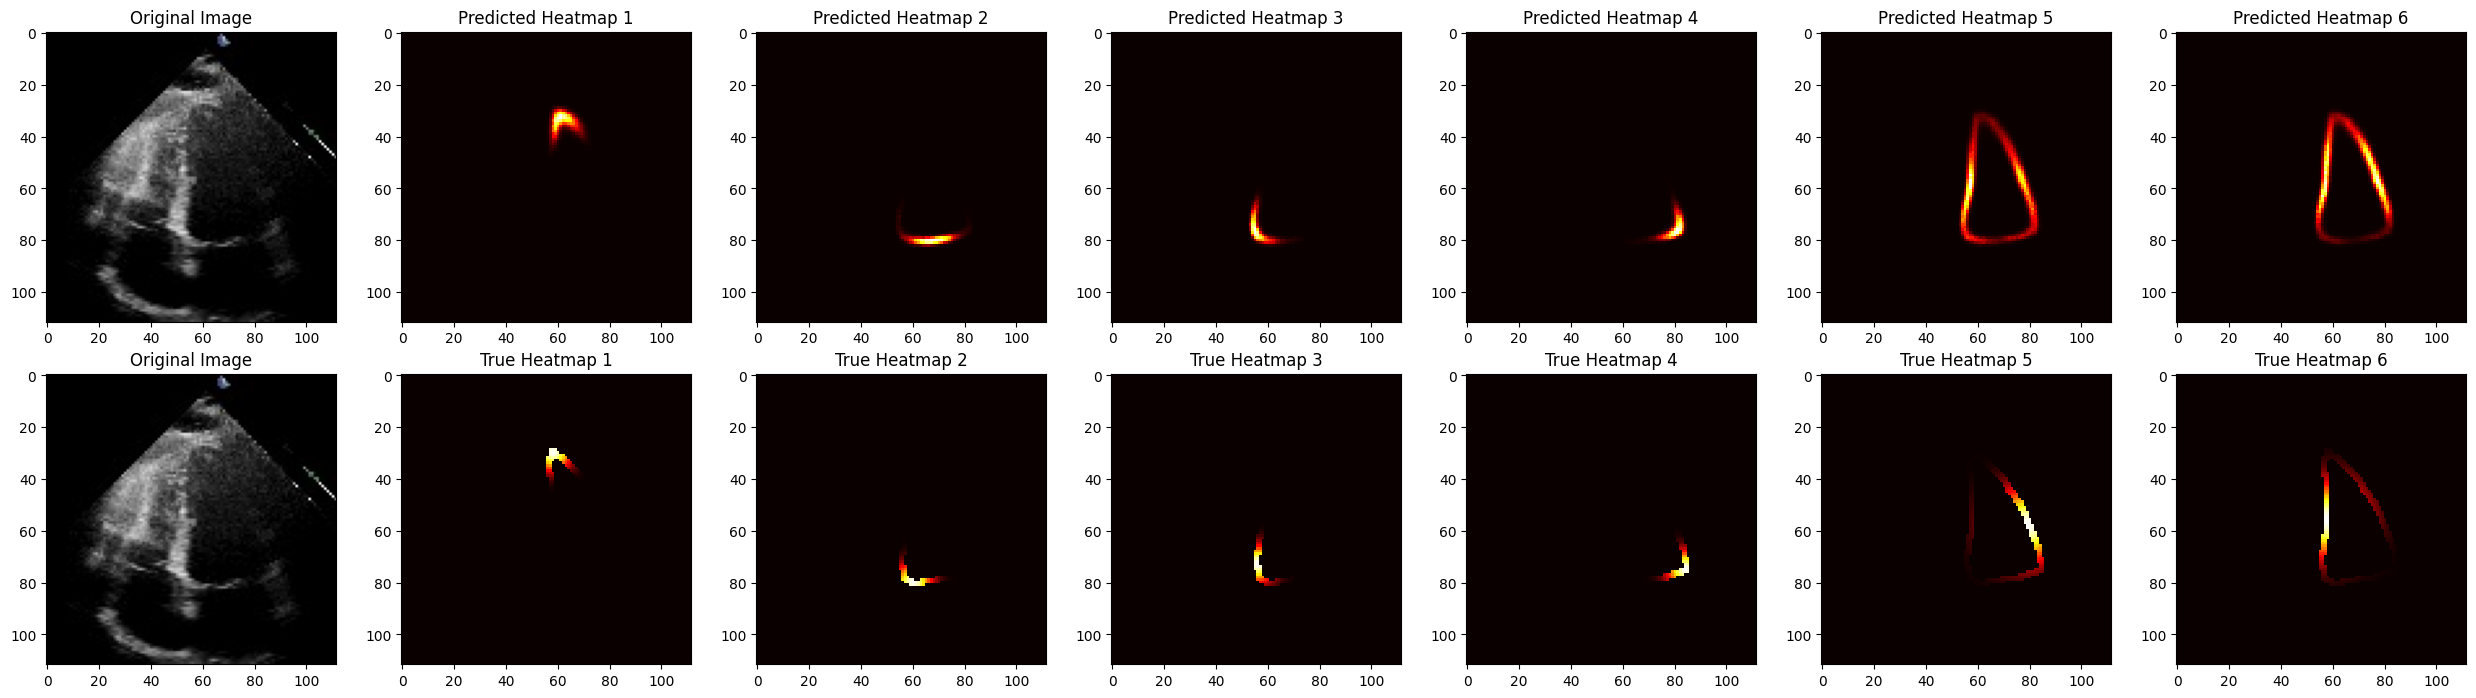

In [18]:
import matplotlib.pyplot as plt
import numpy as np

index = np.random.randint(0, len(test_images))

image = test_images[index]
true_heatmap = test_heatmaps[index]

predicted_heatmap = model.predict(np.expand_dims(image, axis=0))[0]

fig, axs = plt.subplots(2, 7, figsize=(25, 7))

axs[0, 0].imshow(image)
axs[0, 0].title.set_text('Original Image')
axs[1, 0].imshow(image)
axs[1, 0].title.set_text('Original Image')

for i in range(6):
    axs[0, i + 1].imshow(predicted_heatmap[..., i], cmap='hot', interpolation='nearest')
    axs[0, i + 1].title.set_text(f'Predicted Heatmap {i+1}')

for i in range(6):
    axs[1, i + 1].imshow(true_heatmap[..., i], cmap='hot', interpolation='nearest')
    axs[1, i + 1].title.set_text(f'True Heatmap {i+1}')

plt.tight_layout()
plt.show()


# for better visualization we overaly the heatmaps with the image

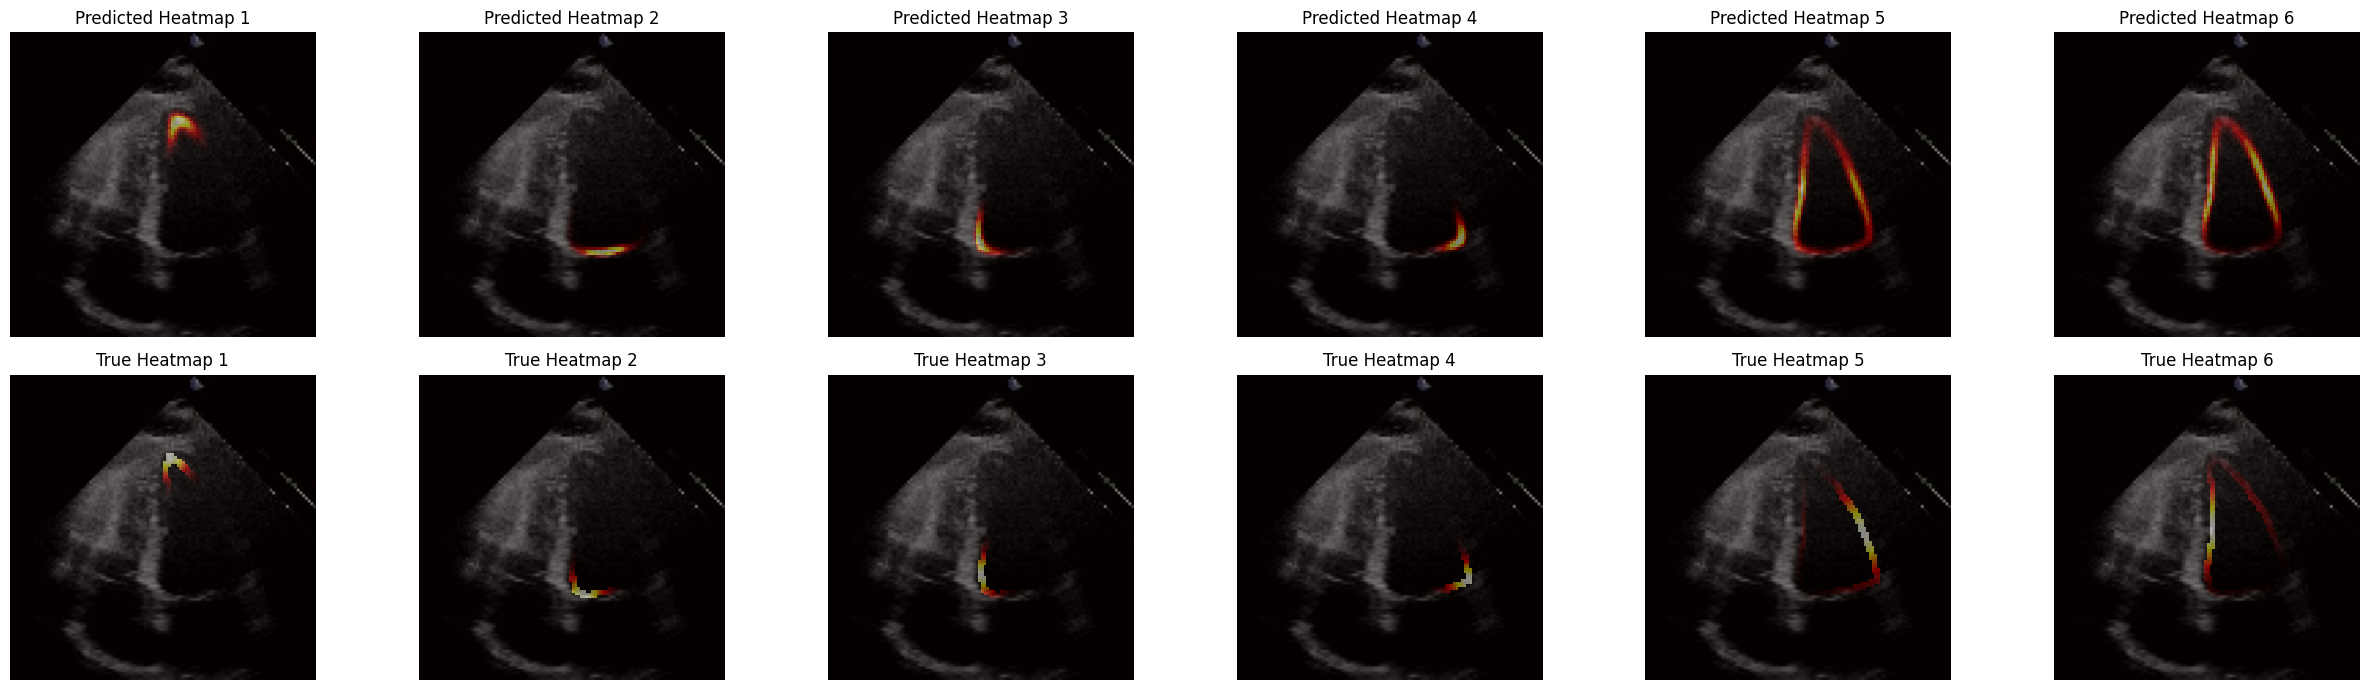

In [19]:
fig, axs = plt.subplots(2, 6, figsize=(25, 7))

for i in range(6):
    axs[0, i].imshow(image, cmap='gray')
    axs[0, i].imshow(predicted_heatmap[..., i], cmap='hot', alpha=0.5, interpolation='nearest')
    axs[0, i].title.set_text(f'Predicted Heatmap {i+1}')

for i in range(6):
    axs[1, i].imshow(image, cmap='gray')
    axs[1, i].imshow(true_heatmap[..., i], cmap='hot', alpha=0.5, interpolation='nearest')
    axs[1, i].title.set_text(f'True Heatmap {i+1}')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


# We extract the landmarks from the heatmaps, we sort them by position, and we create the masks


1/1 [==============================] - 0s 21ms/step


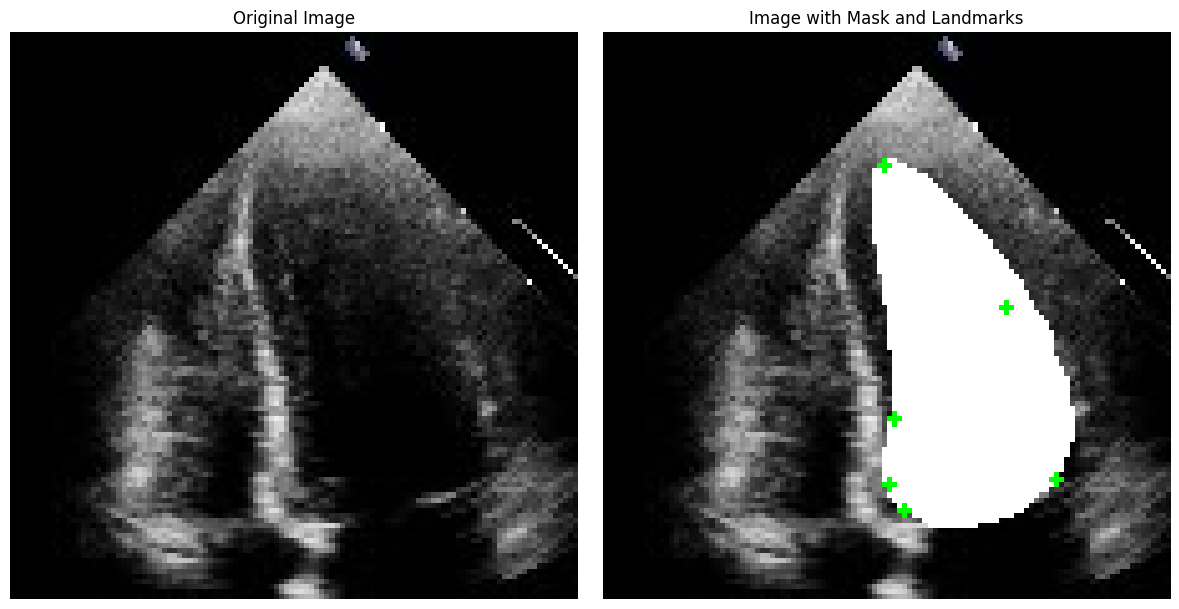

In [27]:
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt
import cv2

def extract_landmarks(heatmap):
    return np.unravel_index(np.argmax(heatmap), heatmap.shape)

def calculate_centroid(points):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    centroid_x = sum(x) / len(points)
    centroid_y = sum(y) / len(points)
    return centroid_x, centroid_y

def sort_points_clockwise(points):
    centroid_x, centroid_y = calculate_centroid(points)
    return sorted(points, key=lambda p: (np.arctan2(p[1] - centroid_y, p[0] - centroid_x), p[0]))

def refined_sort(points):
    sorted_points_angle = sort_points_clockwise(points)

    refined_points = [sorted_points_angle[0]]
    for i in range(1, len(sorted_points_angle)-1):
        current_point = sorted_points_angle[i]
        distances = [(np.linalg.norm(np.array(current_point) - np.array(sorted_points_angle[j])), j)
                     for j in range(i-1, min(i+2, len(sorted_points_angle)))]
        distances.sort(key=lambda x: x[0])
        refined_points.append(sorted_points_angle[distances[0][1]])

    refined_points.append(sorted_points_angle[-1])
    return refined_points

def draw_mask_from_landmarks(image, landmarks, smooth_factor=.01):
    if len(landmarks) < 2:
        return np.zeros_like(image, dtype=np.uint8)

    sorted_landmarks = refined_sort(landmarks)

    sorted_landmarks = np.array(sorted_landmarks).T

    try:
        tck, u = splprep([sorted_landmarks[1], sorted_landmarks[0]], s=smooth_factor, per=True)
    except Exception as e:
        print(f"Error in spline fitting: {e}")
        return np.zeros_like(image, dtype=np.uint8)

    new_points = splev(np.linspace(0, 1, 100), tck)
    points = np.array([new_points[0], new_points[1]]).T.astype(np.int32)

    mask = np.zeros_like(image, dtype=np.uint8)

    cv2.fillPoly(mask, [points], 255)

    return mask

def overlay_mask_on_image(image, mask, landmarks):
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if len(image.shape) == 3 and image.shape[2] == 3:
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    else:
        mask_color = mask

    mask_color = mask_color.astype(image.dtype)

    overlayed_image = cv2.addWeighted(image, 1, mask_color, 0.6, 0)

    for landmark in landmarks:
        cv2.circle(overlayed_image, (landmark[1], landmark[0]), 1, (0, 255, 0), -1)

    return overlayed_image

index = np.random.randint(0, len(valid_images))
image = valid_images[index]
heatmaps = model.predict(np.expand_dims(image, axis=0))[0]

landmarks = [extract_landmarks(heatmaps[..., i]) for i in range(heatmaps.shape[-1])]

sorted_landmarks = refined_sort(landmarks)
mask = draw_mask_from_landmarks(image, sorted_landmarks)

overlayed_image = overlay_mask_on_image(image, mask, landmarks)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(overlayed_image)
axs[1].set_title('Image with Mask and Landmarks')
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [23]:
def extract_probability_line(heatmap, percentile=98):
    thresholded = heatmap > np.percentile(heatmap, percentile)
    return np.argwhere(thresholded)

def find_intersections(left_probability_line, right_probability_line, horizontal_line_y, central_x):
    combined_probability_line = np.concatenate((left_probability_line, right_probability_line), axis=0)

    points_on_line = combined_probability_line[combined_probability_line[:, 0] == horizontal_line_y, :]

    left_points = points_on_line[points_on_line[:, 1] < central_x]
    right_points = points_on_line[points_on_line[:, 1] >= central_x]

    avg_left_point = np.mean(left_points, axis=0) if len(left_points) > 0 else None
    avg_right_point = np.mean(right_points, axis=0) if len(right_points) > 0 else None

    return avg_left_point, avg_right_point


def extract_landmarks(heatmap):
    return np.unravel_index(np.argmax(heatmap), heatmap.shape)

def calculate_centroid(points):
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    centroid_x = sum(x_coords) / len(points)
    centroid_y = sum(y_coords) / len(points)
    return (centroid_x, centroid_y)

def is_point_on_probability_line(avg_point, probability_line, horizontal_line_y):
    points_on_line = probability_line[probability_line[:, 0] == horizontal_line_y, :]
    return any(avg_point[1] == point[1] for point in points_on_line)

def visualize_probability_lines_and_intersections(image, heatmaps, num_horizontal_lines=20):
    plt.imshow(image, cmap='gray')

    top_landmark = extract_landmarks(heatmaps[..., 0])
    bottom_landmark = extract_landmarks(heatmaps[..., 1])
    bottom_left_landmark = extract_landmarks(heatmaps[..., 2])
    bottom_right_landmark = extract_landmarks(heatmaps[..., 3])

    plt.scatter(top_landmark[1], top_landmark[0], c='magenta', s=50, marker='o', label='Top Landmark')
    plt.scatter(bottom_landmark[1], bottom_landmark[0], c='magenta', s=50, marker='o', label='Bottom Landmark')
    plt.scatter(bottom_left_landmark[1], bottom_left_landmark[0], c='magenta', s=50, marker='o', label='Bottom Left Landmark')
    plt.scatter(bottom_right_landmark[1], bottom_right_landmark[0], c='magenta', s=50, marker='o', label='Bottom Right Landmark')

    central_bottom_point = calculate_centroid([bottom_landmark, bottom_left_landmark, bottom_right_landmark])

    #plt.scatter(central_bottom_point[1], central_bottom_point[0], c='magenta', s=50, marker='o', label='Centroid')

    left_probability_line = extract_probability_line(heatmaps[..., -2])
    right_probability_line = extract_probability_line(heatmaps[..., -1])

    plt.scatter(left_probability_line[:, 1], left_probability_line[:, 0], c='blue', s=1, label='Left Probability Line')
    plt.scatter(right_probability_line[:, 1], right_probability_line[:, 0], c='green', s=1, label='Right Probability Line')

    horizontal_line_ys = np.linspace(top_landmark[0], central_bottom_point[0], num_horizontal_lines)[1:-1].astype(int)

    central_x = (top_landmark[1] + central_bottom_point[1]) / 2

    for y in horizontal_line_ys:
        avg_left_intersection, avg_right_intersection = find_intersections(left_probability_line, right_probability_line, y, central_x=central_x)

        if avg_left_intersection is not None:
            plt.scatter(avg_left_intersection[1], avg_left_intersection[0], c='red', s=10, label='Left Intersection' if y == horizontal_line_ys[0] else "")

        if avg_right_intersection is not None:
            plt.scatter(avg_right_intersection[1], avg_right_intersection[0], c='red', s=10, label='Right Intersection' if y == horizontal_line_ys[0] else "")

1/1 [==============================] - 0s 21ms/step


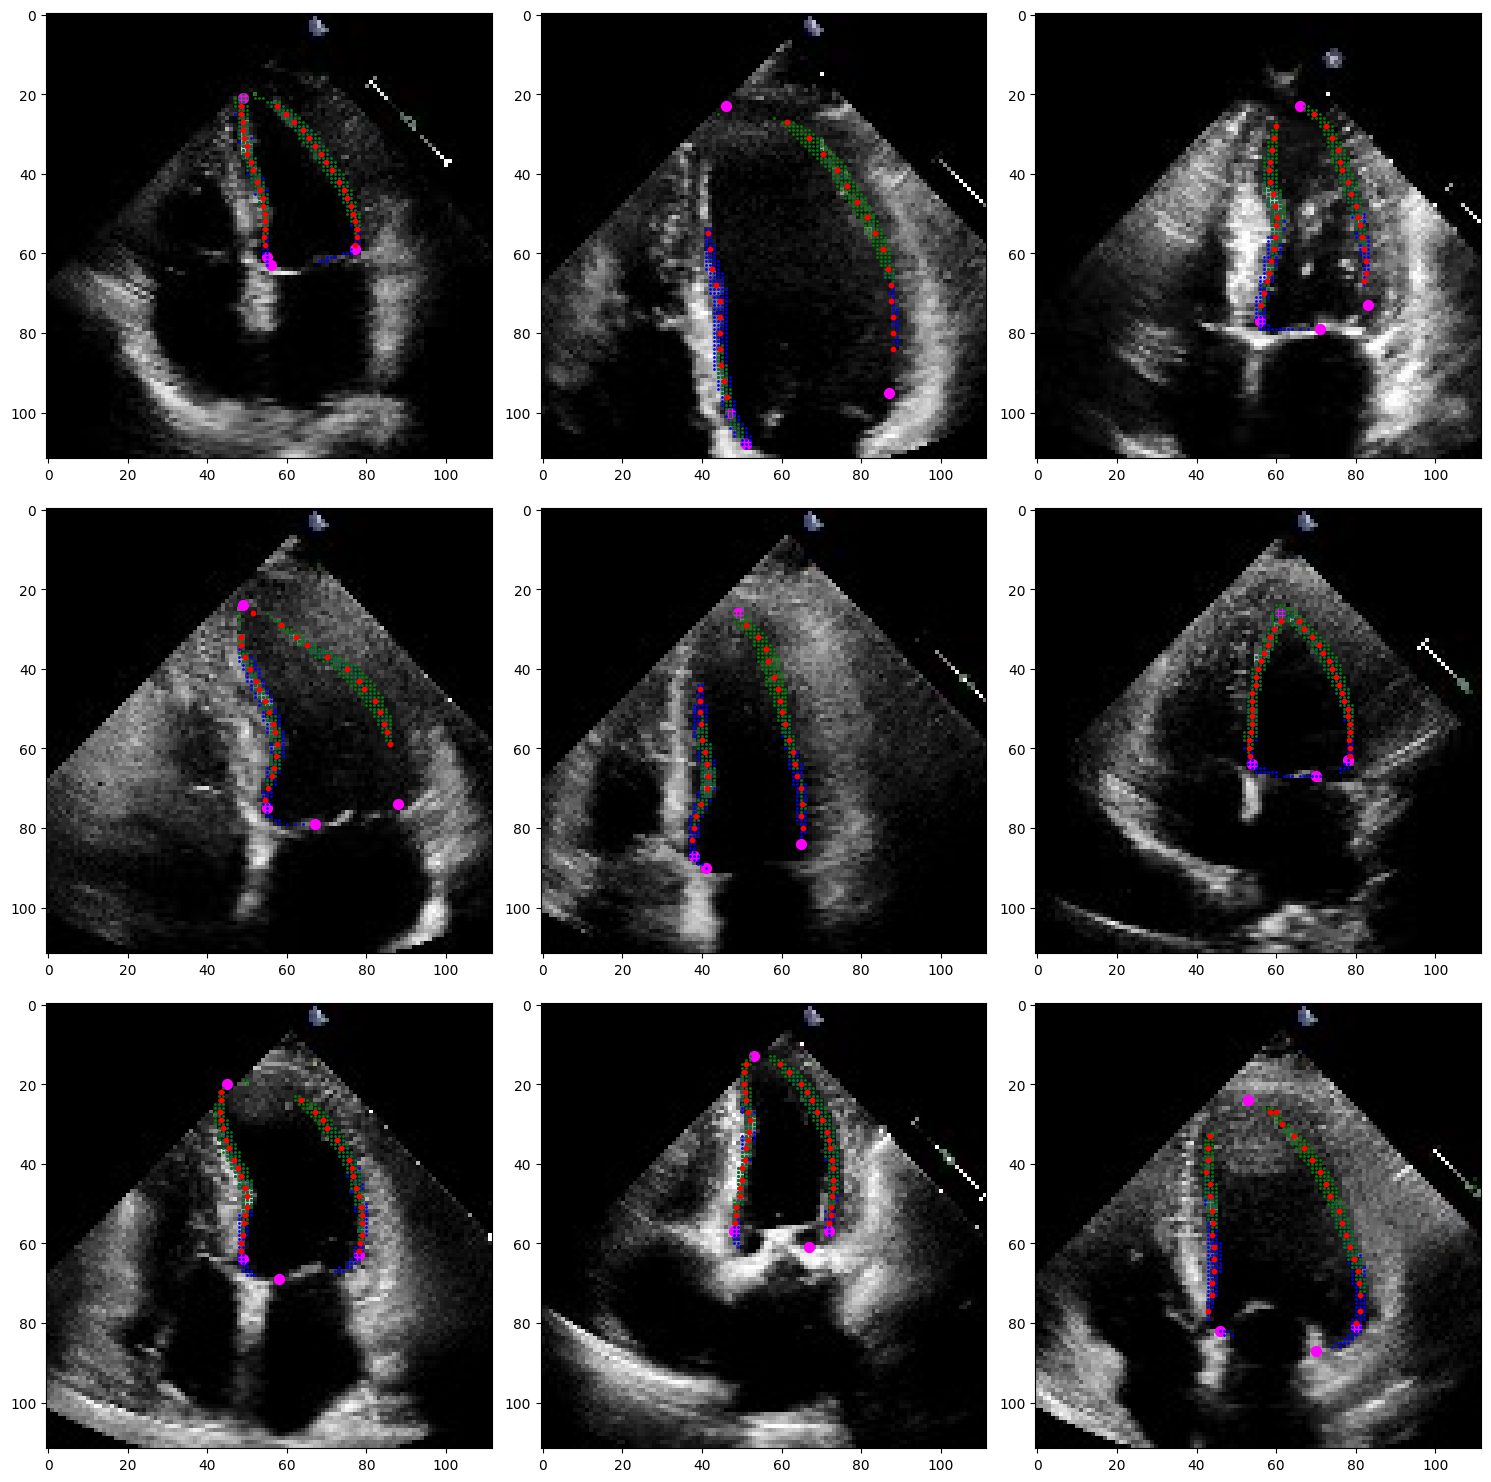

In [24]:
random_indices = np.random.choice(len(test_images), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    image = test_images[idx]
    heatmaps = model.predict(np.expand_dims(image, axis=0))[0]

    plt.sca(axes[i])

    visualize_probability_lines_and_intersections(image, heatmaps)

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


Error in spline fitting, using line drawing method: Invalid inputs.


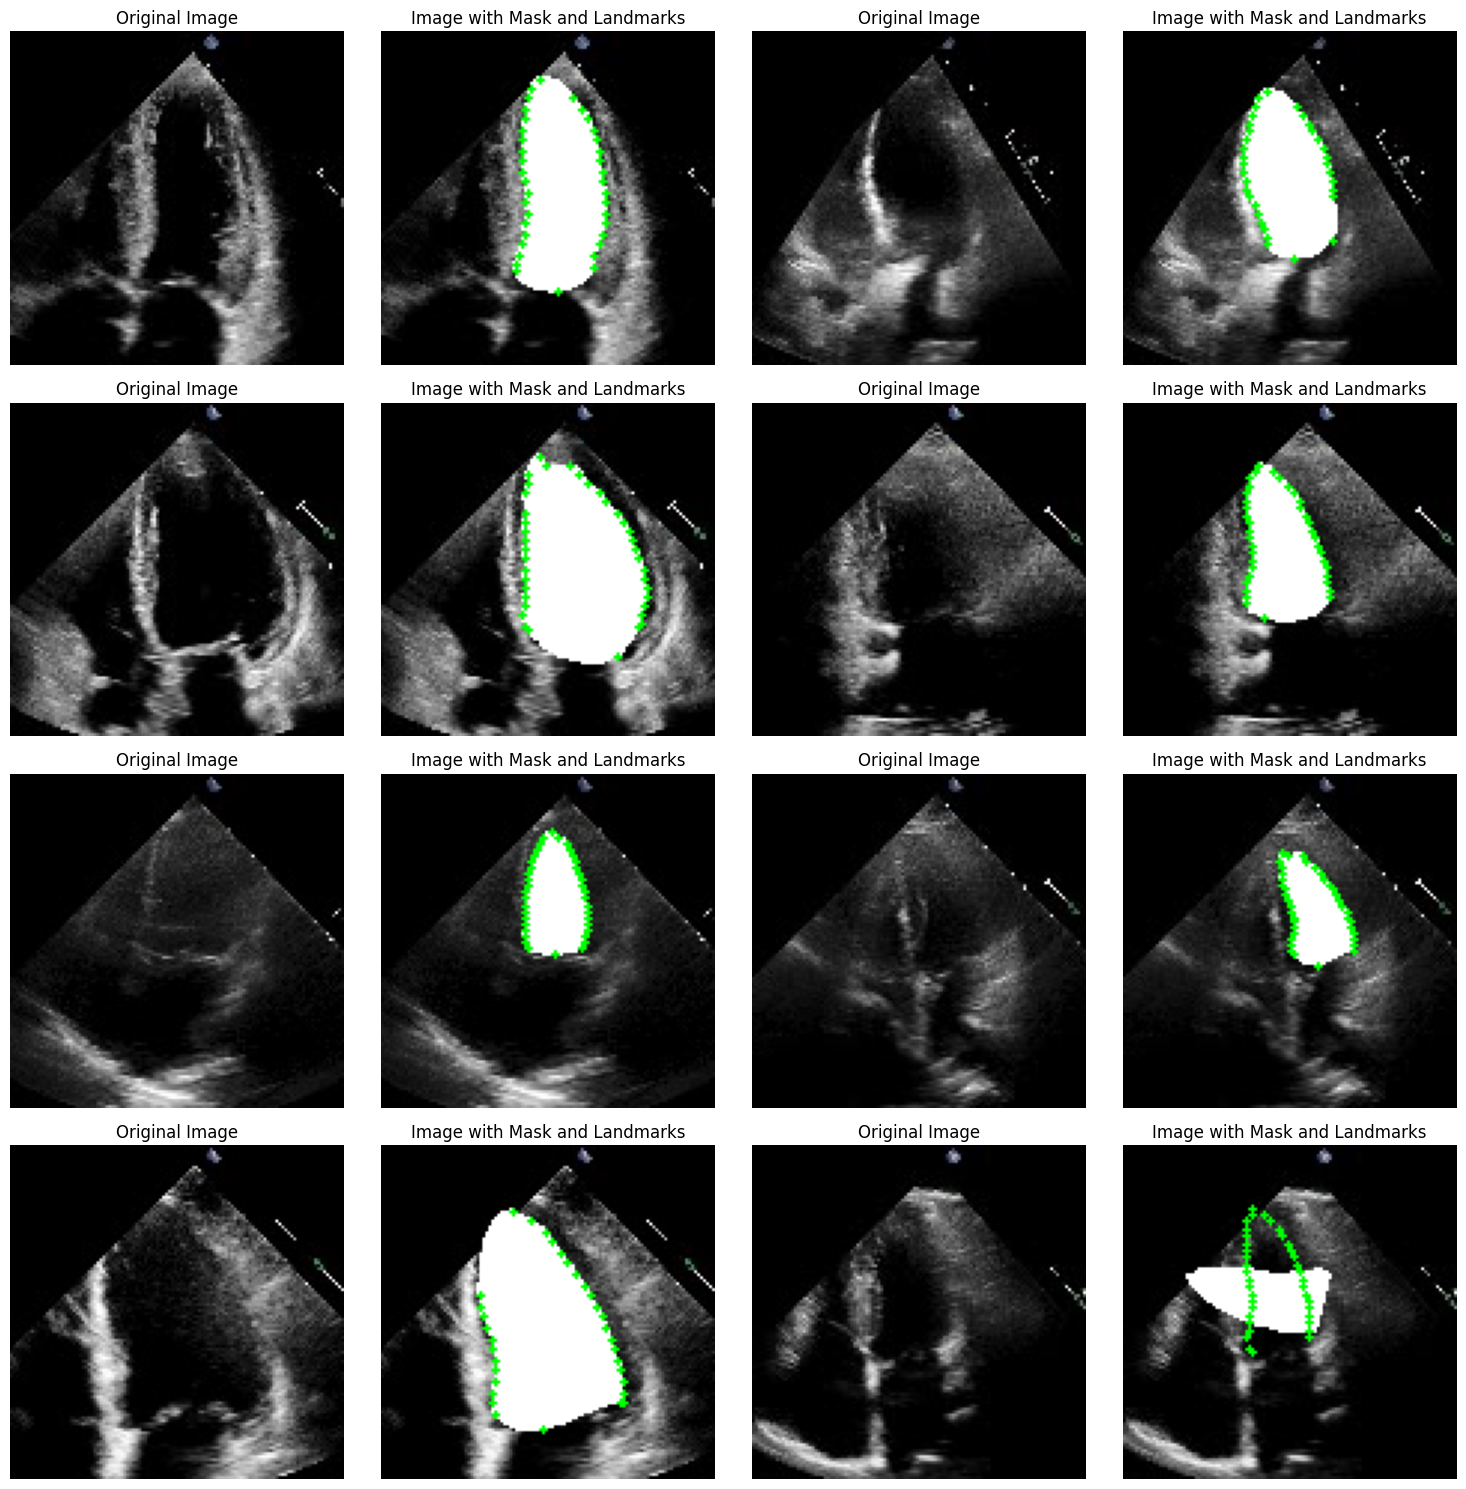

In [41]:
def overlay_mask_on_image(image, mask, landmarks):
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if len(image.shape) == 3 and image.shape[2] == 3:
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    else:
        mask_color = mask

    mask_color = mask_color.astype(image.dtype)

    overlayed_image = cv2.addWeighted(image, 1, mask_color, 0.6, 0)

    for landmark in landmarks:
        if landmark is not None:
            x, y = int(landmark[1]), int(landmark[0])
            cv2.circle(overlayed_image, (x, y), 1, (0, 255, 0), -1)

    return overlayed_image

def process_image_and_generate_mask(image, heatmaps):
    top_landmark = extract_landmarks(heatmaps[..., 0])
    bottom_landmark = extract_landmarks(heatmaps[..., 1])
    bottom_left_landmark = extract_landmarks(heatmaps[..., 2])
    bottom_right_landmark = extract_landmarks(heatmaps[..., 3])

    central_bottom_point = calculate_centroid([bottom_landmark, bottom_left_landmark, bottom_right_landmark])

    left_probability_line = extract_probability_line(heatmaps[..., -2])
    right_probability_line = extract_probability_line(heatmaps[..., -1])

    horizontal_line_ys = np.linspace(top_landmark[0], central_bottom_point[0], 20)[1:-1].astype(int)
    central_x = (top_landmark[1] + central_bottom_point[1]) / 2

    landmarks = [top_landmark, bottom_landmark, bottom_left_landmark, bottom_right_landmark]

    for y in horizontal_line_ys:
        avg_left_intersection, avg_right_intersection = find_intersections(left_probability_line, right_probability_line, y, central_x=central_x)

        if avg_left_intersection is not None:
            landmarks.append(avg_left_intersection)

        if avg_right_intersection is not None:
            landmarks.append(avg_right_intersection)

    sorted_landmarks = sort_points_clockwise(landmarks)

    mask = draw_mask_from_landmarks(image, sorted_landmarks)

    overlayed_image = overlay_mask_on_image(image, mask, landmarks)

    return overlayed_image

def draw_mask_from_landmarks(image, landmarks, smooth_factor=.01):
    if len(landmarks) < 3:
        print("Not enough points for mask generation.")
        return np.zeros_like(image, dtype=np.uint8)

    try:
        landmarks = [(y, x) for (x, y) in landmarks]

        sorted_landmarks = np.array(landmarks).T
        tck, u = splprep(sorted_landmarks, s=smooth_factor, per=True)
        new_points = splev(np.linspace(0, 1, 100), tck)
        points = np.array(new_points).T.astype(np.int32)

    except Exception as e:
        print(f"Error in spline fitting, using line drawing method: {e}")
        points = np.array([(y, x) for (x, y) in landmarks], dtype=np.int32)
        points = np.vstack([points, points[0]])

    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.fillPoly(mask, [points], 255)

    return mask


random_indices = np.random.choice(len(valid_images), 8, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    image = valid_images[idx]
    heatmaps = model.predict(np.expand_dims(image, axis=0))[0]

    overlayed_image = process_image_and_generate_mask(image, heatmaps)

    ax_orig = axes[i*2]
    ax_orig.imshow(image)
    ax_orig.set_title('Original Image')
    ax_orig.axis('off')

    ax_overlay = axes[i*2 + 1]
    ax_overlay.imshow(overlayed_image)
    ax_overlay.set_title('Image with Mask and Landmarks')
    ax_overlay.axis('off')

plt.tight_layout()
plt.show()


Notice how sometimes the mask is in the wrong position, this is because the spline interpolation receives the wrong input, which we havent been able to figure out why since the landmarks are still correctly displayed.